# Línea base de mediciones de CO<sub>2</sub>  - Smart Citizen

Este notebook muestra el proceso que se siguió para calcular la línea base de mediciones de CO<sub>2</sub>  equivalente en los sensores [Smart Citizen](https://smartcitizen.me/kits/). Los datos con los que se trabaja fueron recopilados del portal de la api de Smart Citizen y se encuentran guardados en la base de datos del proyecto [Prototipos de Infraestructura Pública para una Ciudad del Futuro](https://pipciudadfuturo.com/).

El notebook consta de las siguientes partes:

+ Librerías utilizadas
+ Descarga de datos
+ Visualización de datos

## Librerías

Para interactuar con la base de datos y generar el procesmiento de los diferentes datos hemos desarrollado una librería propia `aqiGDL` que almacena las diferentes funciones que son requeridas para el trabajo. Además de la librería desarrollada por [LAC](https://lac.mx) para el proyecto, también se utilizan otras librerías de python para el análisis y visualización de datos.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

import datetime
import textwrap

### Estilos visuales
Utilizamos el estilo visual "Pitaya Smoothie" para la generación de gráficas.

In [2]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Descarga de datos

### Datos históricos de calidad del aire registrados por los sensores

Los datos históricos de exposición a contaminantes atmosféricos estacionarios han sido descargados desde la api de Smart Citizen. Actualmente los datos están disponibles desde la base de datos de PIP.

In [3]:
gdf = aqiGDL.gdf_from_db('smartcitizen', 'public')
gdf.drop_duplicates(inplace=True)
print(gdf.shape)
gdf.head(2)

(176643, 8)


device_id                                              param unit  \
0      13492  Total Volatile Organic Compounds Digital Indoo...  ppb   
1      13492  Total Volatile Organic Compounds Digital Indoo...  ppb   

          lon        lat                  date      value  \
0 -103.389891  20.651647  2021-07-08T22:00:39Z  41.285714   
1 -103.389891  20.651647  2021-07-08T21:00:18Z  76.783333   

                         geometry  
0  POINT (667738.643 2284426.650)  
1  POINT (667738.643 2284426.650)

De los parámetros que se miden por Smart Citizen el que se va a utilizar para la construcción de la línea base será el de dióxido de carbono equivalente, medido en partes por millón (ppm).

In [4]:
gdf.loc[gdf.param=='Equivalent Carbon Dioxide Digital Indoor Sensor'].head(2)

device_id                                            param unit  \
121      13492  Equivalent Carbon Dioxide Digital Indoor Sensor  ppm   
122      13492  Equivalent Carbon Dioxide Digital Indoor Sensor  ppm   

            lon        lat                  date       value  \
121 -103.389891  20.651647  2021-07-08T22:00:39Z  674.785714   
122 -103.389891  20.651647  2021-07-08T21:00:18Z  860.933333   

                           geometry  
121  POINT (667738.643 2284426.650)  
122  POINT (667738.643 2284426.650)

### Red vial de Guadalajara

Con [OSMnx](https://osmnx.readthedocs.io/en/stable/) se descarga la red vial para el área de los sensores

In [5]:
G = ox.graph_from_bbox(20.7900,20.523110,-103.2400,-103.4700)
edges = ox.graph_to_gdfs(G, nodes=False)

### GeoDataFrame con ubicación de sensores

A partir de la tabla que se encuentra en la base de datos de PIP podemos hacer una agrupación por identificador del dispositivo de medición, al agrupar esta obtenemos las coordenadas de cada dispositivo. Al guardar estos datos en una nueva tabla podemos acceder a las ubicacioens más adelante.

In [6]:
gdf_est = gdf[['device_id','lon','lat']].groupby('device_id').mean()
gdf_est = gpd.GeoDataFrame(
    gdf_est, geometry=gpd.points_from_xy(gdf_est.lon, gdf_est.lat))
gdf_est.head(2)

lon        lat                     geometry
device_id                                                    
13483     -103.351588  20.685147  POINT (-103.35159 20.68515)
13492     -103.389890  20.651647  POINT (-103.38989 20.65165)

Con la función multigraph_smartcitizen se contruye la línea base de emisiones de CO<sub>2</sub> . En esta se hace una agrupación del promedio de los datos por día y se grafican como una dispersión de puntos conectados por una línea punteada, para que sea más fácil darle un seguimiento visual a los datos. A su vez, cada punto se acompaña de una barra lateral que muestra una desviación estándar de los valores promedio para comunicar el comportamiento registrado por los sensores a lo largo del día. En el mapa de la izquierda se puede observar la localización del sensor Smart Citizen con respecto a los otros sensores en el AMG.

In [7]:
def multigraph_smartcitizen(device, param, gdf, gdf_est, edges, save=False):
    
    df_temp = gdf[(gdf['device_id']==device) & (gdf['param']==param)].copy()
    df_temp['date'] = pd.to_datetime(df_temp['date'])
    df_temp.set_index('date',inplace=True)
    df_temp = df_temp.resample('D').agg({'value':['mean','std']})
    df_temp.reset_index(inplace=True)
    df_temp['date'] = df_temp['date'].dt.date
    
    df_time1 = df_temp
    
    datelimit = pd.to_datetime("2021-04-01").date()
    
    if len(df_temp[df_temp['date']>datelimit]) > 0:
        
        fig, axes = plt.subplots(1,3,figsize=(24,8))
        
        df_time1 = df_temp[df_temp['date']<datelimit].dropna()
        
        #second period
        df_time2 = df_temp[df_temp['date']>datelimit].dropna()
        axes[2].scatter(df_time2.date, df_time2['value']['mean'], label=param)
        axes[2].plot(df_time2.date, df_time2['value']['mean'], '--', zorder=1, color='white', alpha=0.35)
        axes[2].errorbar(df_time2.date, df_time2['value']['mean'], df_time2['value']['std'], elinewidth=3,linestyle='None', zorder=2, alpha=0.2)

        axes[2].tick_params(axis='x',labelrotation=45)
        axes[1].get_shared_y_axes().join(axes[1], axes[2])
        axes[2].set_yticklabels([])


    else:
    
        fig, axes = plt.subplots(1,2,figsize=(24,8))

    
    #first period
    axes[1].scatter(df_time1.date, df_time1['value']['mean'], label=param)
    axes[1].plot(df_time1.date, df_time1['value']['mean'], '--', zorder=1, color='white', alpha=0.35)
    axes[1].errorbar(df_time1.date, df_time1['value']['mean'], df_time1['value']['std'], elinewidth=3, linestyle='None', zorder=2, alpha=0.2)
    
    axes[1].tick_params(axis='x',labelrotation=45)
    
    plt.ylim(0, None)

    a00 = axes[0]
    shay = a00.get_shared_y_axes()
    shay.remove(a00)
    
    edges.plot(ax=axes[0], color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0], color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_est.plot(ax=axes[0], color='k', alpha=0.85, zorder=1)
    gdf_est[gdf_est.index==device].plot(ax=axes[0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
    axes[0].axis('off')
    estacion = device
    fecha_1 = df_temp.date.min().strftime("%Y-%m-%d")
    fecha_2 = df_temp.date.max().strftime("%Y-%m-%d")
    fig.suptitle(f'Device: {estacion}\nEquivalent Carbon Dioxide (ppm)\n{fecha_1} -- {fecha_2}', fontsize=20)

    if save==True:
        plt.savefig(f'../output/figures/co2_smartcitizen/{device}_{fecha_1}_{fecha_2}.png',dpi=300)

    return plt.show()

En las gráficas resultantes es posible observar que hay dos formatos, uno que contiene solo una gráfica con valores de CO<sub>2</sub> y otra con dos. Esto se debe a que, al analizar los datos pudimos notar que casi todos los sensores dejan de registrar valores a partir de marzo, sin embargo, unos cuantos retoman registros en junio 2021. Esto hizo que hubiera un hueco en los registros y, además de que fuera visualmente confuso, reducía el espacio de la gráfica y no permitía leerla claramente. Para atender esta circunstancia se dividieron los formatos, en las figuras que se muestran dos gráficas de dispersión se retomaron las mediciones en junio y son las que se muestran a la derecha, si solo hay una gráfica el sensor no retomó mediciones. Esta información se puede corroborar en los títulos de lagr gráficas que indican las fechas que se están mostrando y en las etiquetas de las x en la gráfica.

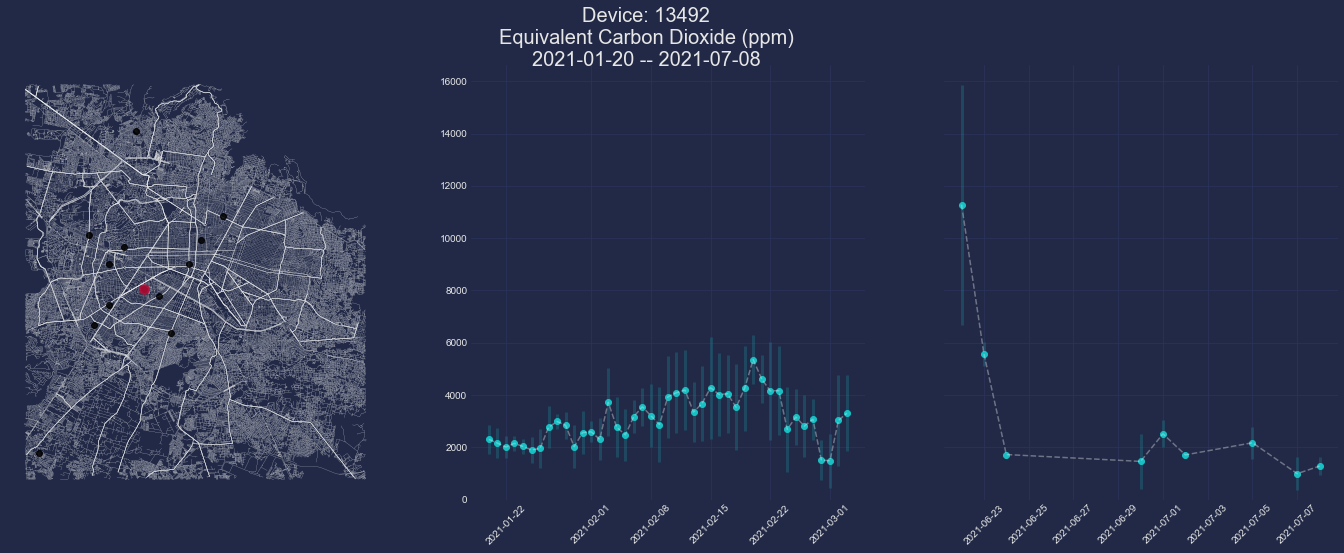

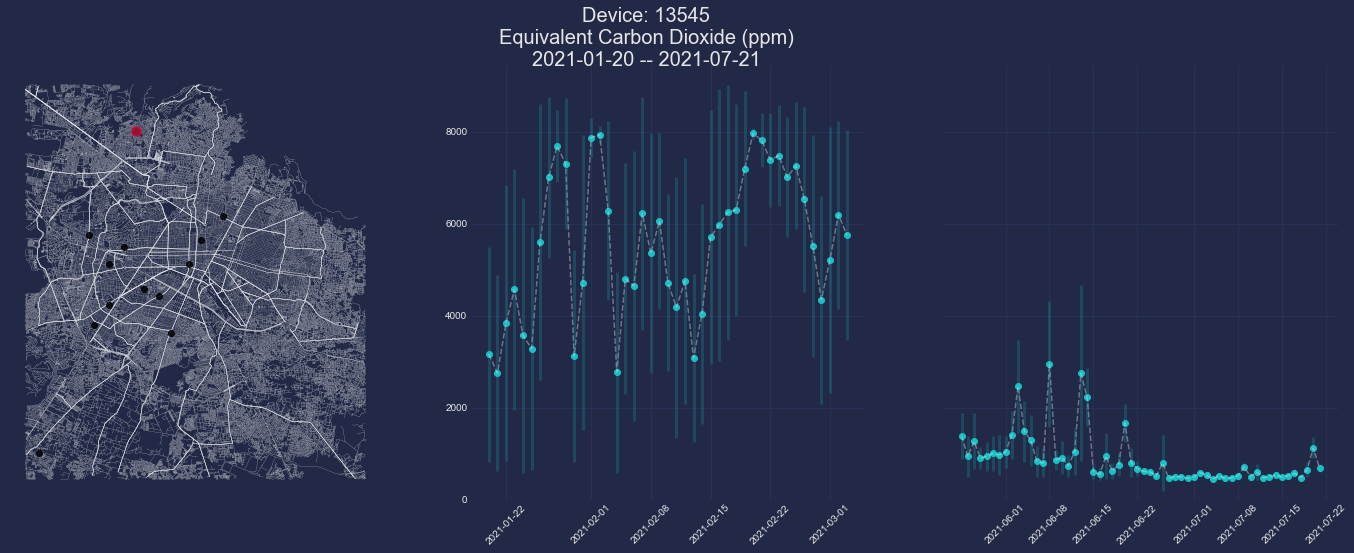

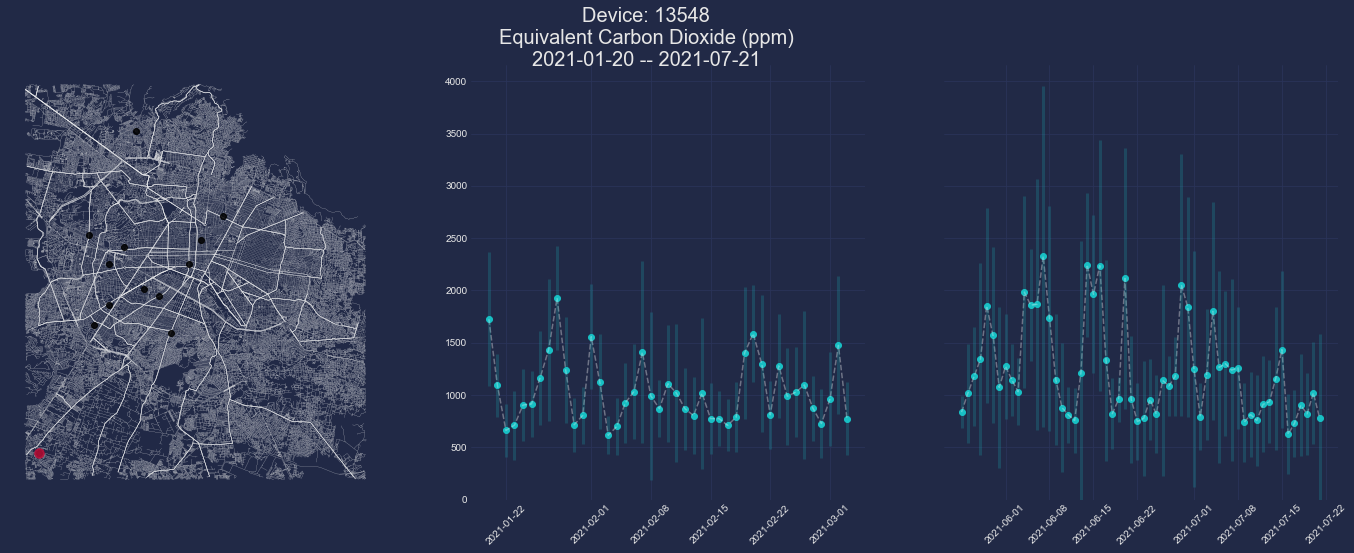

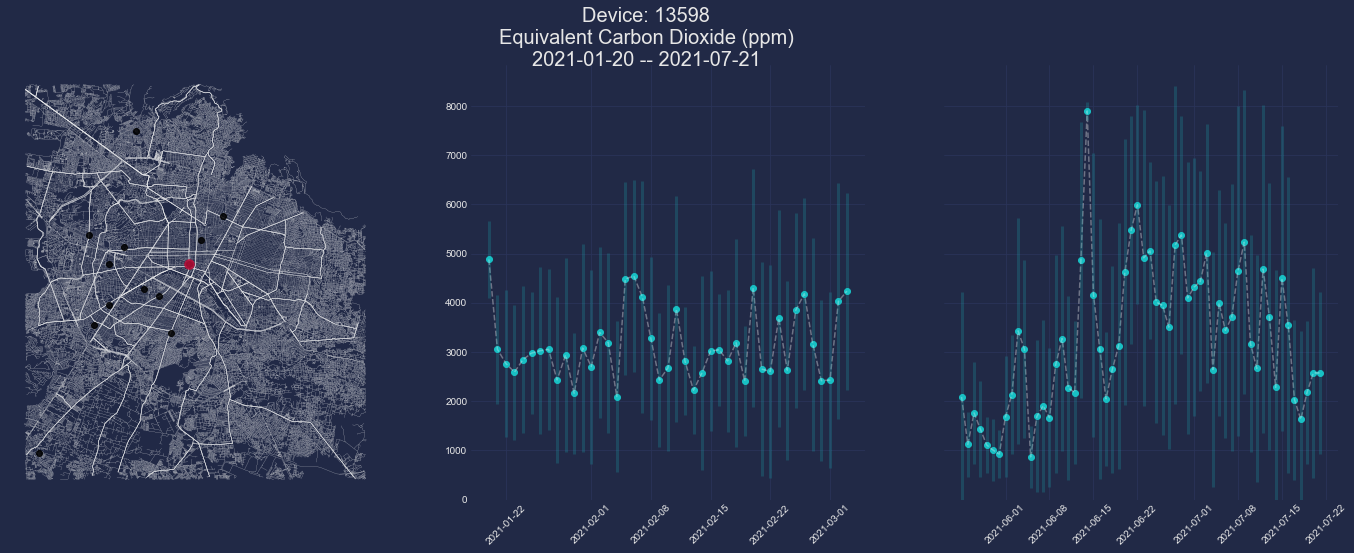

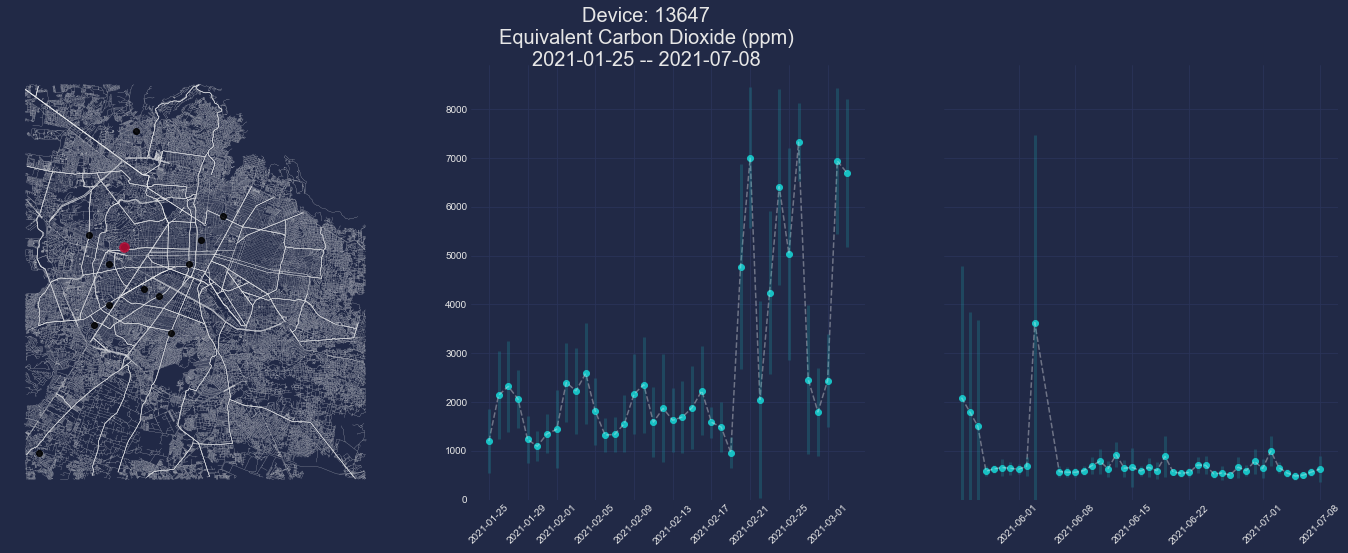

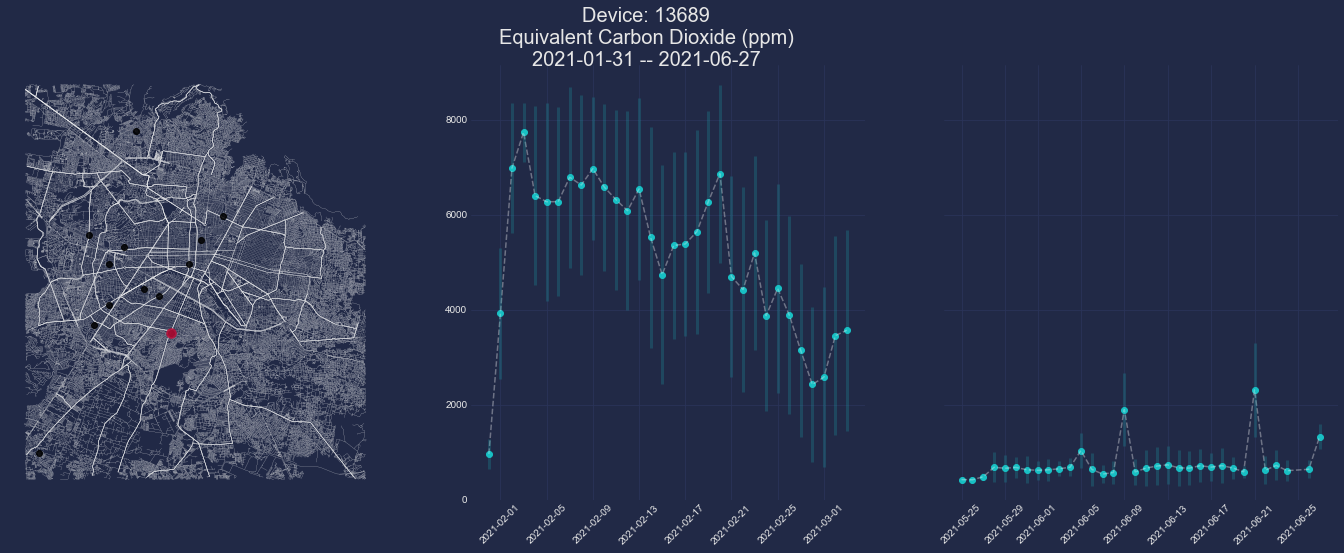

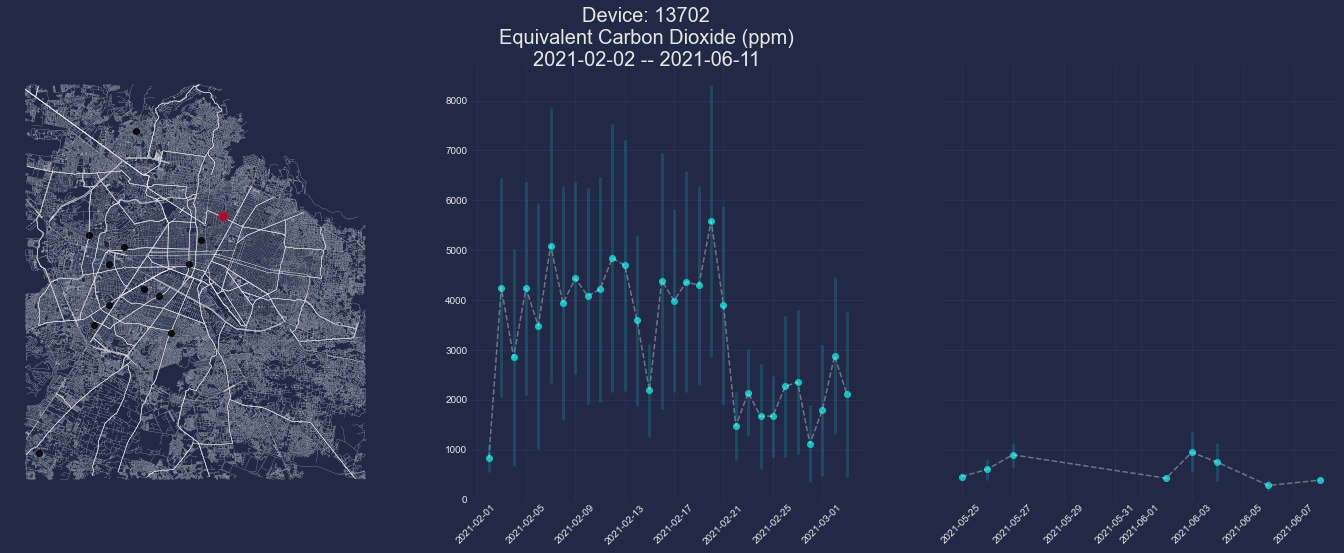

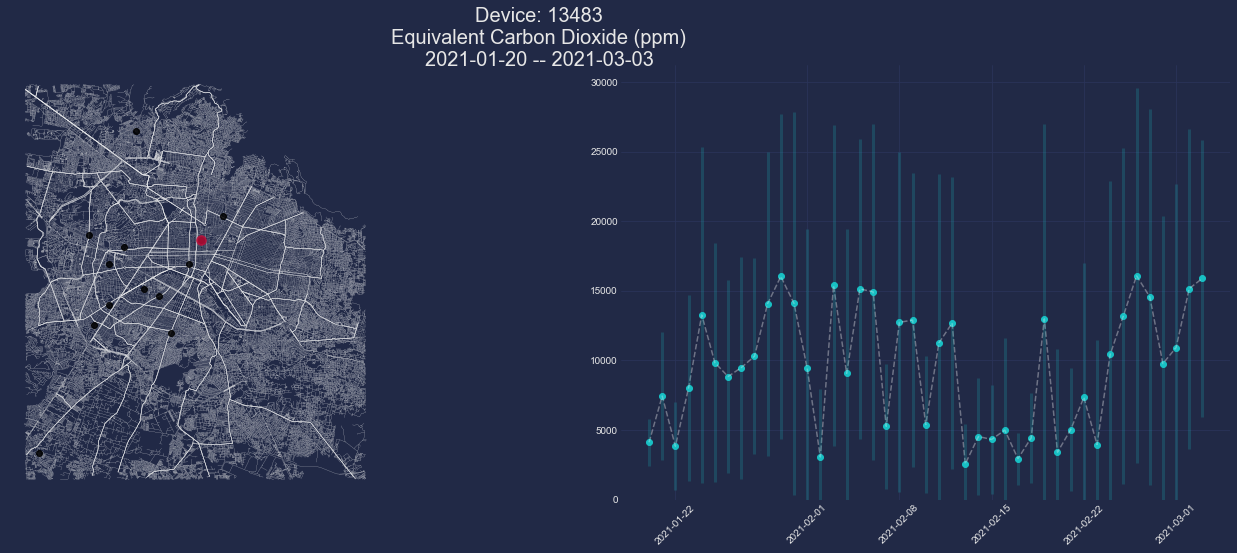

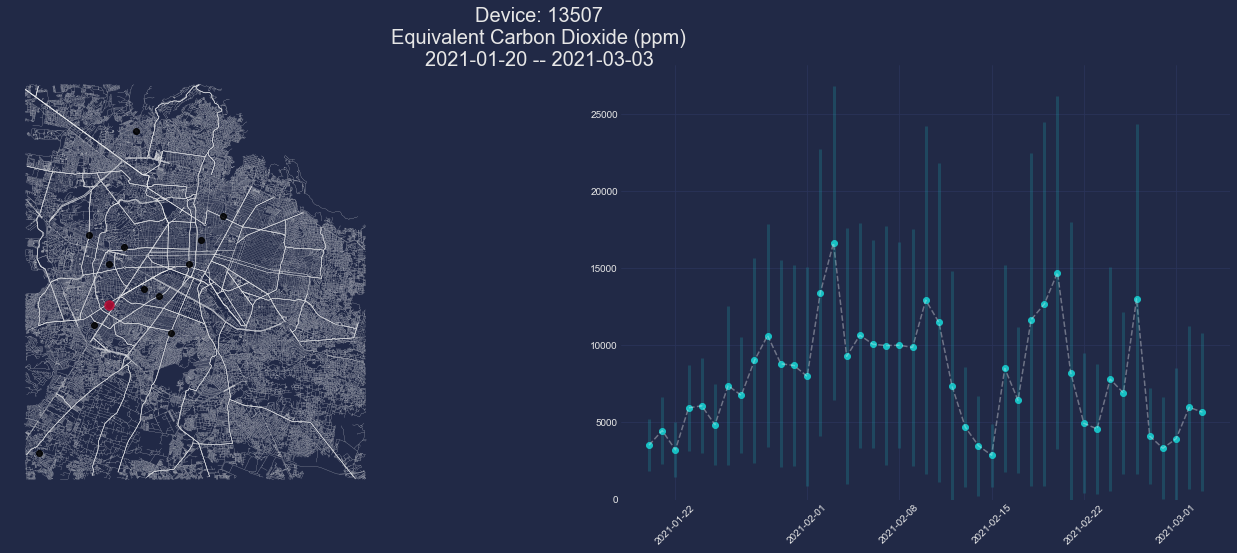

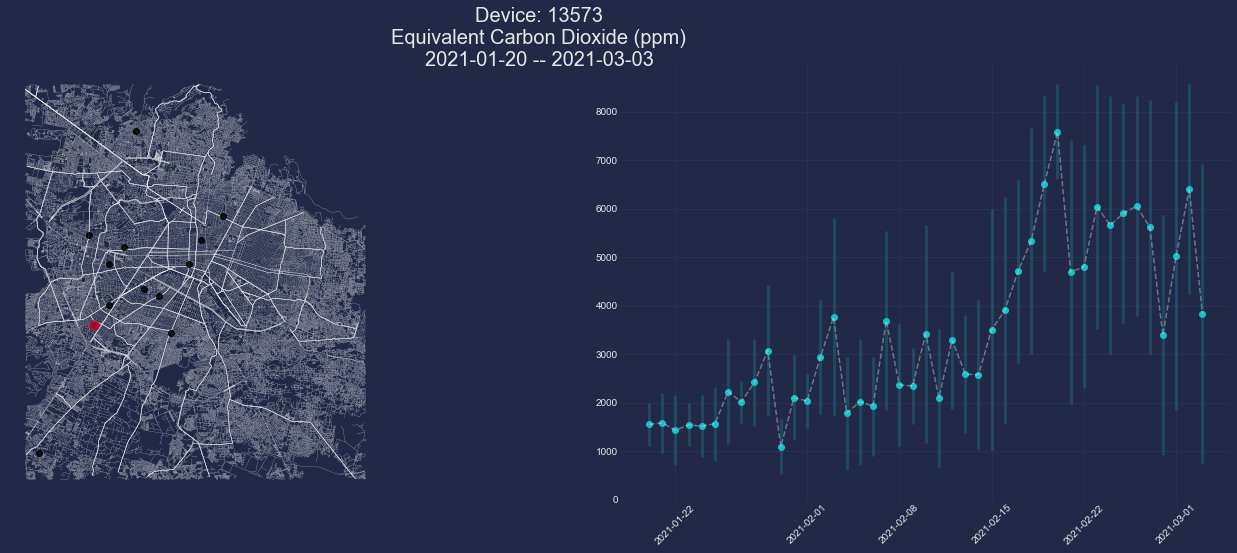

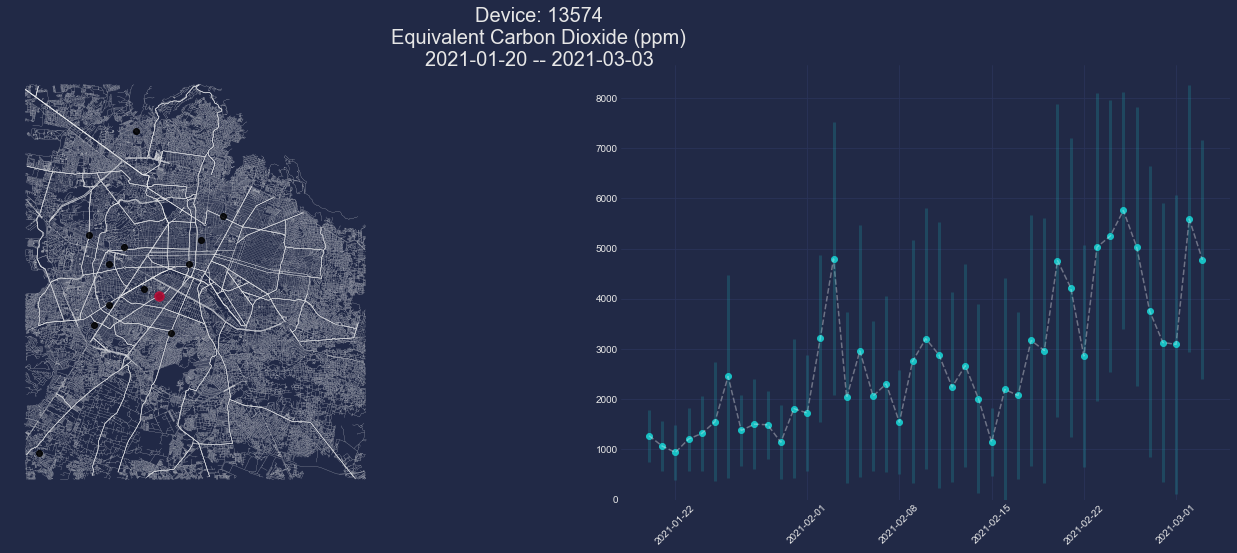

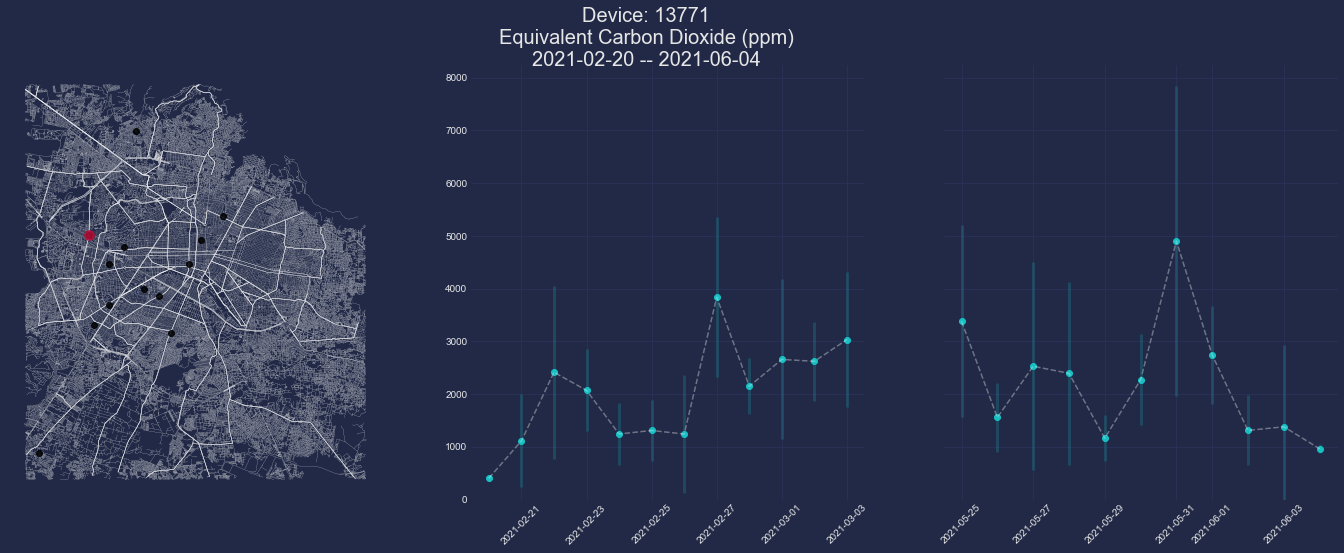

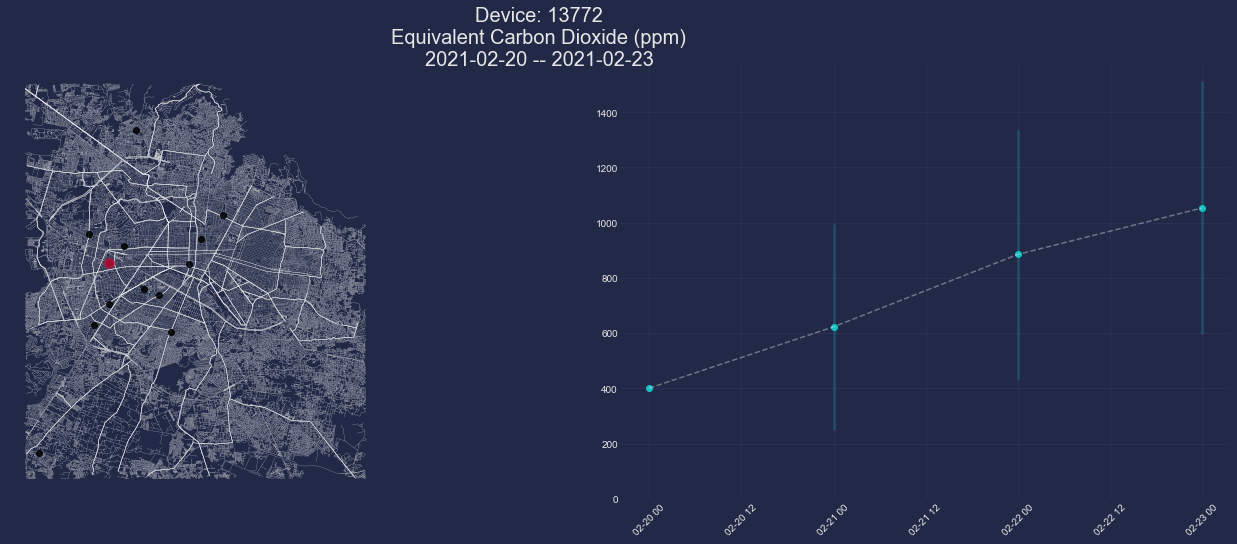

In [8]:
param = 'Equivalent Carbon Dioxide Digital Indoor Sensor'

for est in gdf.device_id.unique():
    multigraph_smartcitizen(est, param, gdf, gdf_est, edges, save=True)